In [1]:
# NOTE: many of the analysis here require large memory, which surpass what jupyter notebook or docker can handle.
# one option is to load only the data you need for a specific sanity check 

In [2]:
# import necessary packages 

import nibabel as nib
from nilearn import image, plotting, datasets
import matplotlib.pyplot as plt
import os
import numpy as np
from joblib import Parallel, delayed
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", message="Casting data from int32 to float32")
from scipy.io import loadmat
from scipy import interpolate
import json

In [3]:
# Interactive function to plot images with given slice coordinates - used for 4D images
def plot_4D(img1, img2=None, img3=None, img4=None, stat_map=False, threshold=0,
               img1_name="", img2_name="", img3_name="", img4_name=""):
    
    '''
    The function take 4D images (loaded with nib.load), draw the img using either stat map or standard plot from nipype 
    image names are used as plot's title 
    '''
    # Determine the number of volumes in the provided images
    num_volumes = image.index_img(img1, slice(0, None)).shape[-1]
    
    # Create text inputs for MNI coordinates
    x_input = widgets.BoundedFloatText(value=0, min=-90, max=90, step=1, description='X Slice')
    y_input = widgets.BoundedFloatText(value=0, min=-126, max=90, step=1, description='Y Slice')
    z_input = widgets.BoundedFloatText(value=0, min=-72, max=108, step=1, description='Z Slice')
    
    # Create a text input for volume selection
    volume_input = widgets.BoundedIntText(value=0, min=0, max=num_volumes - 1, step=1, description='Volume')

    # Arrange the widgets horizontally
    controls = widgets.HBox([x_input, y_input, z_input, volume_input])

    # Function to update the plots
    def update_plots(x_slice, y_slice, z_slice, selected_volume):
        slice_coords = [x_slice, y_slice, z_slice]
        
        def plot_image(img, title_prefix=''):
            if img is not None:
                v = image.index_img(img, selected_volume)
                if not stat_map:
                    display(plotting.plot_img(v, cut_coords=slice_coords, display_mode='ortho', title=f'{title_prefix} - Volume {selected_volume} - Slice {slice_coords}'))
                else:
                    display(plotting.plot_stat_map(v, threshold=threshold, display_mode="ortho", cut_coords=slice_coords, colorbar=False, title=f'{title_prefix} - Volume {selected_volume} - Slice {slice_coords}'))
        
        # Plot the provided images
        plot_image(img1, title_prefix=img1_name)
        plot_image(img2, title_prefix=img2_name)
        plot_image(img3, title_prefix=img3_name)
        plot_image(img4, title_prefix=img4_name)

    # Use interactive_output to create widgets and output
    output = widgets.interactive_output(
        update_plots, 
        {'x_slice': x_input, 'y_slice': y_input, 'z_slice': z_input, 'selected_volume': volume_input}
    )

    # Display the controls and the plot together
    display(widgets.VBox([controls, output]))
 
### nilearn plot ### 
# “x”: sagittal
# “y”: coronal
# “z”: axial
# “ortho”: three cuts are performed in orthogonal directions

### MNI space ###
# y-axis points posterior and anterior
# x-axis: left and right
# z-axis is in the ventral-dorsal 

In [4]:
# Interactive function to plot images with given slice coordinates
def plot_3D(img1, img2=None, img3=None, img4=None, stat_map=False, threshold=0,
            img1_name="", img2_name="", img3_name="", img4_name=""):
    
    '''
    The function take 3D images (loaded with nib.load), draw the img using either stat map or standard plot from nipype 
    image names are used as plot's title 
    '''

    # Create text inputs for MNI coordinates
    x_input = widgets.BoundedFloatText(value=0, min=-90, max=90, step=1, description='X Slice')
    y_input = widgets.BoundedFloatText(value=0, min=-126, max=90, step=1, description='Y Slice')
    z_input = widgets.BoundedFloatText(value=0, min=-72, max=108, step=1, description='Z Slice')

    # Arrange the widgets horizontally
    controls = widgets.HBox([x_input, y_input, z_input])

    # Function to update the plots
    def update_plots(x_slice, y_slice, z_slice):
        slice_coords = [x_slice, y_slice, z_slice]
        
        def plot_image(img, title_prefix=''):
            if img is not None:
                if not stat_map:
                    display(plotting.plot_img(img, cut_coords=slice_coords, display_mode='ortho', title=f'{title_prefix} - Slice {slice_coords}'))
                else:
                    display(plotting.plot_stat_map(img, threshold=threshold, display_mode="ortho", cut_coords=slice_coords, colorbar=False, title=f'{title_prefix} - Slice {slice_coords}'))

        # Plot the provided images
        plot_image(img1, title_prefix=img1_name)
        plot_image(img2, title_prefix=img2_name)
        plot_image(img3, title_prefix=img3_name)
        plot_image(img4, title_prefix=img4_name)

    # Use interactive_output to create widgets and output
    output = widgets.interactive_output(
        update_plots, 
        {'x_slice': x_input, 'y_slice': y_input, 'z_slice': z_input}
    )

    # Display the controls and the plot together
    display(widgets.VBox([controls, output]))

In [5]:
def plot_diff(diff_array, slice_indices):
    
    '''
    The function take an array (designed for array showing difference between two images but can be used for other purpose as long as the input is numpy array)
    and plot it as gray map 
    '''
    # Determine min and max values for the colorbar
    vmin = np.min(diff_array)
    vmax = np.max(diff_array)
    
    # Create a figure with a gridspec layout
    fig = plt.figure(figsize=(18, 12))
    nrows = 1 + len(slice_indices) // 5
    ncols = 5
    gs = gridspec.GridSpec(nrows, ncols, figure=fig, wspace=0.4, hspace=0.2)
    
    # Plot each slice
    axes = []
    for i, slice_index in enumerate(slice_indices):
        ax = fig.add_subplot(gs[i])
        axes.append(ax)
        im = ax.imshow(diff_array[:, :, slice_index].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(f'Slice {slice_index}')
        ax.axis('off')

    # Add a single colorbar for the entire figure
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Difference')

    plt.show()

In [6]:
# Function to calculate temporal signal to noise for a given voxel
def compute_tsnr_voxel(voxel_time_series):
    mean_signal = np.mean(voxel_time_series)
    std_signal = np.std(voxel_time_series)
    return mean_signal / std_signal if std_signal != 0 else 0

# Function to calculate tSNR for all voxels 
def compute_tsnr(mri_data, n_jobs=4):
    # Flatten the 3D spatial dimensions to apply parallel processing
    voxels = mri_data.reshape(-1, mri_data.shape[-1])

    # Use Parallel to compute tSNR for each voxel in parallel
    tsnr_flat = Parallel(n_jobs=n_jobs)(delayed(compute_tsnr_voxel)(voxels[i]) for i in range(voxels.shape[0]))

    # Reshape back to the original 3D spatial dimensions
    tsnr = np.array(tsnr_flat).reshape(mri_data.shape[:3])
    
    return tsnr

In [7]:
def resample_onset(onset_list, TR, num_vol):
    '''
    resample the onset time point to the scale of volume 
    e.g. experiment last for 400ms, onsets are set on milisecond scale, can get value from 1 to 400
    TR = 2, only 200 data points, need to resample onset to scale that it takes values from 1 to 200  
    '''
    # Convert onset times to milliseconds and round to integer
    onset_ms = np.round(onset_list.squeeze() * 1000).astype(int)
    
    # Calculate the total experiment duration in milliseconds
    TR_ms = TR * 1000
    exp_duration_ms = int(TR_ms * num_vol)
    
    # Create the original time scale in milliseconds
    scale_ms = np.arange(0, exp_duration_ms, 1)
    
    # Create an indicator array for onset times
    onset_ms_ind = np.zeros(shape=scale_ms.shape)
    onset_ms_ind[onset_ms] = 1
    
    # Create the new time scale in TR units
    scale_TR = np.arange(0, exp_duration_ms, TR_ms)
    
    # Resample using interpolation
    resampler = interpolate.interp1d(scale_ms, onset_ms_ind, kind='cubic')
    onset_TR_ind = resampler(scale_TR)
    
    # Extract indices where the value is 1
    onset_TR = [i for i, x in enumerate(onset_TR_ind) if x != 0]
    
    return onset_TR

In [8]:
##### USER's INPUTS #####
raw_dir = '/data' # path to raw data location 
experiment_dir = '/output' # base path for outputs 
workflow_name = 'spm_preproc1'
output_dir = f'datasink/{workflow_name}' #output path 

sub = 'sub-01'
task = 'task-emodet'

In [9]:
# load original image 
ori_img_path = os.path.join(experiment_dir, output_dir, sub, task, f'{sub}_{task}_bold_roi.nii')
ori_img = nib.load(ori_img_path)
ori_data = ori_img.get_fdata()

In [10]:
##### SLICE TIMING #####

# load image after slice timing 
a_img_path = os.path.join(experiment_dir, output_dir, sub, task, f"a{sub}_{task}_bold_roi.nii")
a_img = nib.load(a_img_path)
a_data = a_img.get_fdata()

In [11]:
# plot original image against resliced image 
plot_4D(ori_img, a_img)

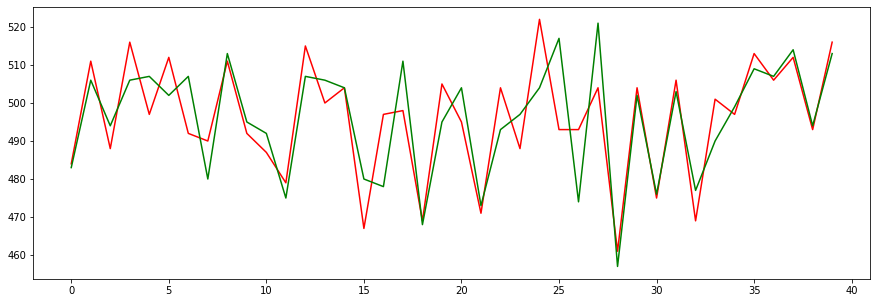

In [12]:
# plot some time series of voxels of choices before and after slice timing and also some from reference slice

# idx = [20, 60, 9] #reference slice has last axis 9 or 28 , sanity check if the reference slice stay the same
idx = [32, 32, 15] #other slice to check if the signal change as expected, e.g. signal of slice acquired before ref slice
                #should be like being push forward - early part is cut sind its original signal is assumed to be acquired too early) 
                #should maintain activity pattern/dynamic
                #Note: be careful, multiband sequence, larger indices do not always mean later capturing
                    
a_series = a_data[tuple(idx)][10:50]
ori_series = ori_data[tuple(idx)][10:50] 

plt.figure(figsize=(15,5))
plt.plot(ori_series, color = 'red')
plt.plot(a_series, color = 'green')
plt.show()

In [14]:
# calculate tSNR before and after slice timing
# please uncomment the next lines to run the calculation, since the output files are large, they are stored immediately
# they are able to be reloaded using the last 3 lines 

# tsnr_before = compute_tsnr(ori_data[:, :, :, 5:])
# tsnr_after = compute_tsnr(a_data)
# tsnr_diff = tsnr_after - tsnr_before

# # # Save to binary files
# np.save(f'{experiment_dir}/{output_dir}/{sub}/{task}/{sub}_tsnr_before.npy', tsnr_before)
# np.save(f'{experiment_dir}/{output_dir}/{sub}/{task}/{sub}_tsnr_after.npy', tsnr_after)
# np.save(f'{experiment_dir}/{output_dir}/{sub}/{task}/{sub}_tsnr_diff.npy', tsnr_diff)

# load tSNR:
tsnr_before = np.load(f'{experiment_dir}/{output_dir}/{sub}/{task}/{sub}_tsnr_before.npy')
tsnr_after = np.load(f'{experiment_dir}/{output_dir}/{sub}/{task}/{sub}_tsnr_after.npy')
tsnr_diff = np.load(f'{experiment_dir}/{output_dir}/{sub}/{task}/{sub}_tsnr_diff.npy')

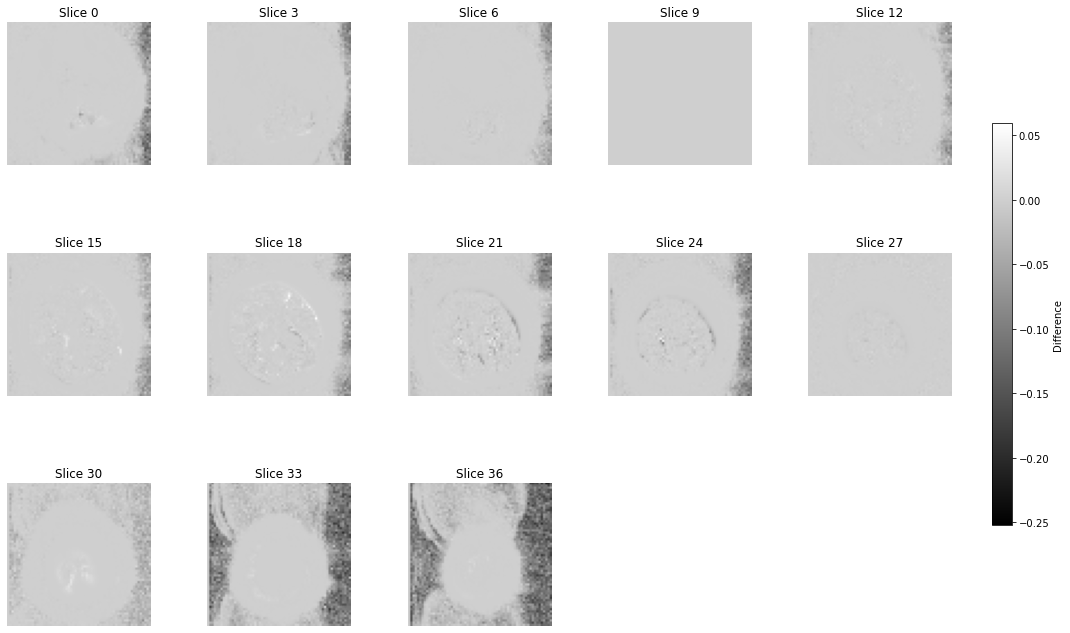

In [19]:
# plot the difference 

slice_indices = np.arange(0,38,3)
plot_diff(tsnr_diff, slice_indices)

#NOTE: sub06 shows some improvement in tSNR after slice timing (in brain area)

In [9]:
### Motion Correction ###

#load the realigned image and the mean image

ra_img_path = os.path.join(experiment_dir, output_dir, sub, task, f"ra{sub}_{task}_bold_roi.nii")
ra_img = nib.load(ra_img_path)
ra_data = ra_img.get_fdata()

mean_img_path = os.path.join(experiment_dir, output_dir, sub, task, f"meana{sub}_{task}_bold_roi.nii")
mean_img = nib.load(mean_img_path)

In [14]:
### data before and after realignment ### ignore template behind, only plot to see if data pattern change 
plot_4D(ori_img, ra_img, stat_map=True, threshold=600, img1_name='Original Image', img2_name='Realigned Image')

In [2]:
### load realignment parameter ###
par_file_path = os.path.join(experiment_dir, output_dir, sub, task, f'rp_a{sub}_{task}_bold_roi.txt')
par = np.loadtxt(par_file_path)

trans_mm = par[:, :3]
rot_degrees = np.degrees(par[:, 3:])

NameError: name 'os' is not defined

Text(0.5, 0, 'volume')

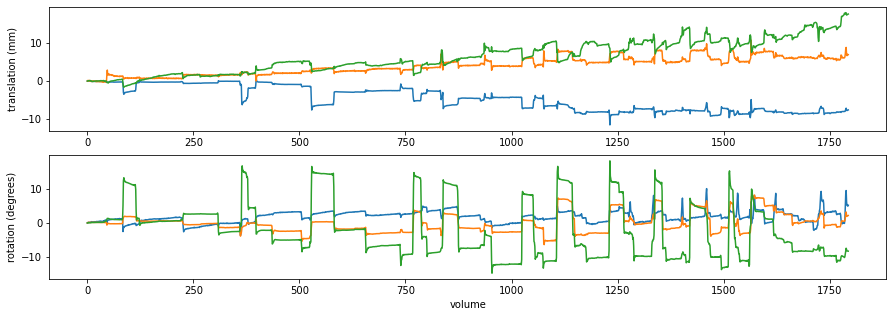

In [16]:
### plot realignment parameter ###
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('translation (mm)')
axes[0].plot(trans_mm)

axes[1].set_ylabel('rotation (degrees)')
axes[1].plot(rot_degrees)

axes[1].set_xlabel('volume')

#QUESTION (sub06): motion larger than 1 voxel, consider exclude this subject? 

In [17]:
### test if participant movement correlate with certain condition: visualization ###

# onsets need to be sample to scale of volume 
#NOTE: resampling onsets is not perfect, loosing onsets 

# load TR and duration:
task_info_path = os.path.join(raw_dir, sub, 'func', f'{sub}_{task}_bold.json')
with open(task_info_path, 'rt') as fp:
    task_info = json.load(fp)
    
num_vol = task_info['dcmmeta_shape'][-1]-5  #-5 first 5 volumes 
TR = task_info['RepetitionTime']

# load onsets
onsets_file_path = os.path.join(raw_dir, sub, 'func', f'{sub}_{task}_onsets.mat')
onsets = loadmat(onsets_file_path)

morph_0_100 = onsets['onsets'][0][0]
morph_40_60 = onsets['onsets'][0][1]
morph_50_50 = onsets['onsets'][0][2]
morph_45_55 = onsets['onsets'][0][3]

# resampling onset to scale of TR
morph_0_100_ds = resample_onset(morph_0_100, TR, num_vol)
morph_40_60_ds = resample_onset(morph_40_60, TR, num_vol)
morph_50_50_ds = resample_onset(morph_50_50, TR, num_vol)
morph_45_55_ds = resample_onset(morph_45_55, TR, num_vol)

Text(0.5, 0, 'Volume')

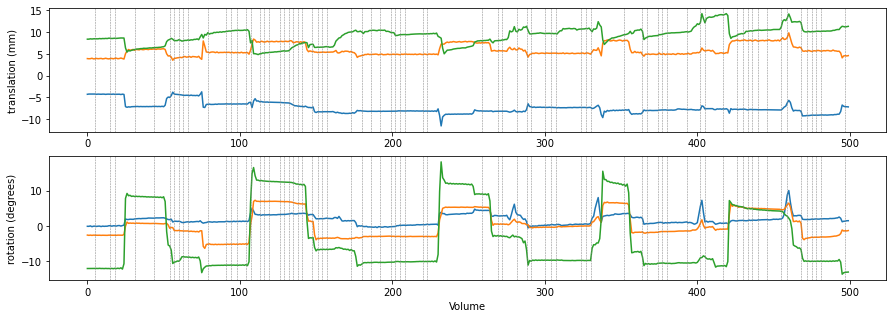

In [18]:
# plot the onsets together with realignment parameter

# ran = (0, trans_mm.shape[0]) # plot all time points 
ran = (1000, 1500) # plot a chunk based on choise 
conditions = [morph_0_100_ds, morph_40_60_ds, morph_50_50_ds, morph_45_55_ds] #include all conditions or some of them based on choice

fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('translation (mm)')
axes[0].plot(trans_mm[ran[0]:ran[1]])

for condition in conditions:
    for i in condition:
        if ran[0] <= i <= ran[1]:
            onset = i-ran[0]
            axes[0].axvline(x=onset, color='gray', linestyle='--', linewidth=0.5)

axes[1].set_ylabel('rotation (degrees)')
axes[1].plot(rot_degrees[ran[0]:ran[1]])

for condition in conditions:
    for i in condition:
        if ran[0] <= i <= ran[1]:
            onset = i-ran[0]
            axes[1].axvline(x=onset, color='gray', linestyle='--', linewidth=0.5)

axes[1].set_xlabel('Volume')

In [9]:
##### COREGISTRATION #####

# load mean image and realigned anatomical image 
mean_img_path = os.path.join(experiment_dir, output_dir, sub, task, f"meana{sub}_{task}_bold_roi.nii")
mean_img = nib.load(mean_img_path)

r_anat_img_path = os.path.join(experiment_dir, output_dir, sub, task, f'r{sub}_T1w.nii')
r_anat_img = nib.load(r_anat_img_path)

In [11]:
# plot mean and relaigned anatomical image
plot_3D(mean_img, r_anat_img, img1_name='Mean Functional Image', img2_name='Anatomical Image')

In [12]:
##### SEGMENTATION #####

# load bias corrected anatomical image and realigned anatomical image 
m_img_path = os.path.join(experiment_dir, output_dir, sub, task, f"mr{sub}_T1w.nii")
m_img = nib.load(m_img_path)

r_anat_img_path = os.path.join(experiment_dir, output_dir, sub, task, f'r{sub}_T1w.nii')
r_anat_img = nib.load(r_anat_img_path)

In [13]:
# plot coregistered, bias corrected
plot_3D(r_anat_img, m_img, 
        img1_name='Realigned Anatomical Image',
        img2_name='Bias-Corrected Anatomical Image')

#QUESTION: where to find segmented anatomical image? 

In [14]:
##### NORMALIZATION #####

# load mgi template, warped anatomical and funtional image 
mni_img = datasets.load_mni152_template()

w_anat_img_path = os.path.join(experiment_dir, output_dir, sub, task, f'wmr{sub}_T1w.nii')
w_anat_img = nib.load(w_anat_img_path)

w_img_path = os.path.join(experiment_dir, output_dir, sub, task, f'wra{sub}_{task}_bold_roi.nii')
w_img = nib.load(w_img_path)

In [15]:
# plot template and normalized anatomical image and functional image of choice 

vol_idx = 500
vol = image.index_img(w_img, index=vol_idx)

plot_3D(mni_img, w_anat_img, vol, img1_name='MNI Template', img2_name='Normalized Anatomical Image', img3_name=f'Functional Image: Volume {vol_idx}')

In [32]:
##### SMOOTHING #####

# load original image, smoothed imaged with different fwhm 
ori_img_path = os.path.join(experiment_dir, output_dir, sub, task, f'{sub}_{task}_bold_roi.nii')
ori_img = nib.load(ori_img_path)

s4_img_path = os.path.join(experiment_dir, output_dir, sub, task, f'fwhm-4swra{sub}_{task}_bold_roi.nii')
s4_img = nib.load(s4_img_path)

s8_img_path = os.path.join(experiment_dir, output_dir, sub, task, f'fwhm-8swra{sub}_{task}_bold_roi.nii')
s8_img = nib.load(s8_img_path)

In [33]:
#plot original image and 2 smoothed image 
plot_4D(ori_img, s4_img, s8_img, img1_name='Original Image', img2_name='Smooth Image - FWHM 4', img3_name='Smooth Image - FWHM 8')

#QUESTION (sub06): FWHM of 8 seem too much of smoothing, how to decide fwhm, right frontal temporal area still quite bright, how to deal with that
#QUESTION (sub01): frontal area bright 

In [30]:
!tree /output/datasink/spm_preproc1 #check the folder structure 

/output/datasink/spm_preproc1
├── sub-01
│   └── task-emodet
│       ├── asub-01_task-emodet_bold_roi.nii
│       ├── fwhm-4swrasub-01_task-emodet_bold_roi.nii
│       ├── fwhm-8swrasub-01_task-emodet_bold_roi.nii
│       ├── meanasub-01_task-emodet_bold_roi.nii
│       ├── mrsub-01_T1w.nii
│       ├── rasub-01_task-emodet_bold_roi.nii
│       ├── rp_asub-01_task-emodet_bold_roi.txt
│       ├── rsub-01_T1w.nii
│       ├── sub-01_task-emodet_bold_roi.nii
│       ├── wmrsub-01_T1w.nii
│       └── wrasub-01_task-emodet_bold_roi.nii
└── sub-06
    └── task-emodet
        ├── asub-06_task-emodet_bold_roi.nii
        ├── fwhm-4swrasub-06_task-emodet_bold_roi.nii
        ├── fwhm-8swrasub-06_task-emodet_bold_roi.nii
        ├── meanasub-06_task-emodet_bold_roi.nii
        ├── mrsub-06_T1w.nii
        ├── rasub-06_task-emodet_bold_roi.nii
        ├── rp_asub-06_task-emodet_bold_roi.txt
        ├── rsub-06_T1w.nii
        ├── sub-06_task-emodet_bold_roi.nii
        ├── wmrsub-06_T1w.nii
       

# TEST AREA:

# ARCHIEVED:

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from nilearn import plotting, image

# Interactive function to plot images with given slice coordinates
def plot_slices(img1, img2):
    # Determine the number of volumes in both images
    img1_volumes = image.index_img(img1, slice(0, None)).shape[-1]
    img2_volumes = image.index_img(img2, slice(0, None)).shape[-1]
    max_volumes = max(img1_volumes,img2_volumes)
    
    # Create sliders for MNI coordinates
    x_slider = widgets.IntSlider(min=-90, max=90, step=1, description='X Slice')
    y_slider = widgets.IntSlider(min=-126, max=90, step=1, description='Y Slice')
    z_slider = widgets.IntSlider(min=-72, max=108, step=1, description='Z Slice')
    
    # Create a slider for volume selection
    volume_slider = widgets.IntSlider(min=0, max=max_volumes - 1, step=1, description='Volume', continuous_update=False)

    # Function to update the plots
    def update_plots(x_slice, y_slice, z_slice, selected_volume):
        slice_coords = [x_slice, y_slice, z_slice]
        volume1 = image.index_img(img1, selected_volume)
        volume2 = image.index_img(img2, selected_volume)
        
        display(plotting.plot_img(volume1, cut_coords=slice_coords, display_mode='ortho', title=f'Volume {selected_volume} - Slice {slice_coords}'))
        display(plotting.plot_img(volume2, cut_coords=slice_coords, display_mode='ortho'))

    # Use interactive to create widgets and output
    interactive_plot = widgets.interactive(
        update_plots, 
        x_slice=x_slider, 
        y_slice=y_slider, 
        z_slice=z_slider, 
        selected_volume=volume_slider
    )
    display(interactive_plot)

In [ ]:
# Interactive function to plot images with given slice coordinates
def plot_slices(img1, img2, stat_map=False, threshold=0):
    # Determine the number of volumes in both images
    vs1 = image.index_img(img1, slice(0, None)).shape[-1]
    vs2 = image.index_img(img2, slice(0, None)).shape[-1]
    max_volumes = max(vs1, vs2)
    
    # Create text inputs for MNI coordinates
    x_input = widgets.BoundedFloatText(value=0, min=-90, max=90, step=1, description='X Slice')
    y_input = widgets.BoundedFloatText(value=0, min=-126, max=90, step=1, description='Y Slice')
    z_input = widgets.BoundedFloatText(value=0, min=-72, max=108, step=1, description='Z Slice')
    
    # Create a text input for volume selection
    volume_input = widgets.BoundedIntText(value=0, min=0, max=max_volumes - 1, step=1, description='Volume')

    # Function to update the plots
    def update_plots(x_slice, y_slice, z_slice, selected_volume):
        slice_coords = [x_slice, y_slice, z_slice]
        v1 = image.index_img(img1, selected_volume)
        v2 = image.index_img(img2, selected_volume)
        
        if not stat_map:
            display(plotting.plot_img(v1, cut_coords=slice_coords, display_mode='ortho', title=f'Volume {selected_volume} - Slice {slice_coords}'))
            display(plotting.plot_img(v2, cut_coords=slice_coords, display_mode='ortho'))
        else:
            display(plotting.plot_stat_map(
                v1, threshold=threshold, display_mode="ortho", cut_coords=slice_coords, colorbar=False, title=f'Volume {selected_volume} - Slice {slice_coords}'
            ))

            display(plotting.plot_stat_map(
                v2, threshold=threshold, display_mode="ortho", cut_coords=slice_coords, colorbar=False
            ))


    # Use interactive to create widgets and output
    interactive_plot = widgets.interactive(
        update_plots, 
        x_slice=x_input, 
        y_slice=y_input, 
        z_slice=z_input, 
        selected_volume=volume_input
    )
    display(interactive_plot)
    
# “x”: sagittal
# “y”: coronal
# “z”: axial
# “ortho”: three cuts are performed in orthogonal directions
# y-axis points posterior and anterior
# x-axis: left and right
# z-axis is in the ventral-dorsal 

In [ ]:
volume_list = [5, 530, 1530]
diff_slice_list = [10, 22, 36]

# Create subplots for each volume
num_rows = len(volume_list)
num_cols = len(diff_slice_list)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, v in enumerate(volume_list):
    volume = image.index_img(ori_img, v)
    r_volume = image.index_img(ra_img, v)
    
    volume_data = volume.get_fdata()
    r_volume_data = r_volume.get_fdata()
    diff = abs(volume_data - r_volume_data)
    
    for j, s in enumerate(diff_slice_list):
        diff_slice = diff[:, :, s]

        ax = axes[i, j] if num_rows > 1 else axes[j]
        im = ax.imshow(diff_slice.T, cmap='gray', origin='lower', vmin=0, vmax=np.max(diff))
        ax.set_title(f'Volume {v} - Slice {s}')
        ax.axis('off')
        
        if j%2==0:
            fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()